In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 7.3MB/s 
     |████████████████████████████████| 460kB 56.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-05-06 04:39:28--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::22c2:513, ...
Conn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Load data and preprocessing

In [3]:
#load data
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fe06c89f650>)

In [4]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('total data :',len(total_data))
total_data[:5]

total data : 200000


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


if the rating is more than 3 then set 1 as label otherwise, 0

In [6]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


count the number of samples excluding duplicates

In [10]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [9]:
#Check null
print(total_data.isnull().values.any())

False


Split test and train data, and then check the distribution of the data

train set : 150000
test set : 50000
   label  count
0      0  75076
1      1  74924
   label  count
0      0  24961
1      1  25039


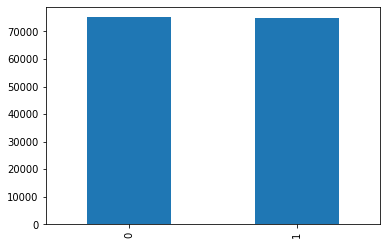

In [19]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('train set :', len(train_data))
print('test set :', len(test_data))

# almost 50%/50%
print(train_data.groupby('label').size().reset_index(name = 'count'))
print(test_data.groupby('label').size().reset_index(name = 'count'))

#check distribution
train_data['label'].value_counts().plot(kind = 'bar')
# test_data['label'].value_counts().plot(kind = 'bar')

Preprocessing

In [20]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [22]:
#remove duplicates
test_data.drop_duplicates(subset = ['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

#replace white space to null
test_data['reviews'].replace('', np.nan, inplace=True)

#remove null
test_data = test_data.dropna(how='any')

Tokenizer

In [114]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

#remove stopwords
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [115]:
#caculate the frequency of two cases, which words mainly appear in positive reviews and negative reviews.
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [116]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('네요', 31898), ('는데', 20303), ('안', 19749), ('어요', 14846), ('있', 13150), ('너무', 13108), ('했', 11758), ('배송', 9832), ('좋', 9766), ('같', 8993), ('거', 8909), ('구매', 8852), ('어', 8775), ('없', 8770), ('아요', 8624), ('습니다', 8432), ('되', 8390), ('그냥', 8380), ('잘', 8031), ('않', 7916)]
[('좋', 39592), ('아요', 21104), ('네요', 19841), ('어요', 18602), ('잘', 18535), ('구매', 16238), ('습니다', 13515), ('있', 12421), ('배송', 12323), ('는데', 11684), ('합니다', 9790), ('했', 9733), ('먹', 9611), ('재', 9361), ('너무', 8389), ('같', 7820), ('만족', 7297), ('거', 6556), ('쓰', 6367), ('어', 6289)]


Negative reviews show longer length compare to the positive reviews

Average length of positive reviews : 13.584859324115103
Average length of negative reviews : 17.038187969524216


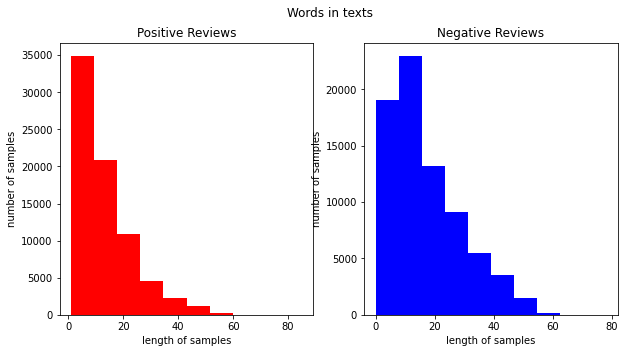

In [117]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('Average length of positive reviews :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('Average length of negative reviews :', np.mean(text_len))
plt.show()

In [118]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

Word to index

In [119]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [120]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # number of the word that's less than threshold
total_freq = 0
rare_freq = 0 # total frequency of the word that's less than threshold

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('size of the vocabulary:',total_cnt)
print('the number of word that appear less than %s times: %s'%(threshold - 1, rare_cnt))
print("ratio of the rare word:", (rare_cnt / total_cnt)*100)
print("ratio of the appearance of the rare word:", (rare_freq / total_freq)*100)

size of the vocabulary: 40103
the number of word that appear less than 1 times: 18286
ratio of the rare word: 45.5975862154951
ratio of the appearance of the rare word: 0.7960849650695193


In [121]:
#remove the word that appears only once, we take it as unimportant
vocab_size = total_cnt - rare_cnt + 2

print(vocab_size)

21819


In [122]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])
print(X_test[:3])

[[83, 234, 36, 181, 62, 113, 14, 12, 229, 485, 370, 27, 15, 12], [46, 6753, 7341, 6471, 296, 7, 10, 20, 27, 15, 46, 2596, 11350, 97, 548, 262, 360, 10, 20, 17, 8, 17, 275, 74, 250, 916, 224, 1861, 1077, 254, 49, 51, 29, 1150, 308], [818, 7, 24, 38, 12, 905, 7, 188, 27, 15, 6]]
[[262, 10, 3, 6, 976, 112, 1040, 611, 97, 209, 1161, 8, 2, 191, 58, 23, 179, 44, 42, 308], [518, 7, 3948, 17, 567, 8, 4, 62, 3, 483], [21, 9, 11, 533, 175, 1228, 7, 18, 4, 1505, 56, 3, 2]]


Padding - mostly less than 60

max length : 85
avg length : 15.313273333333333


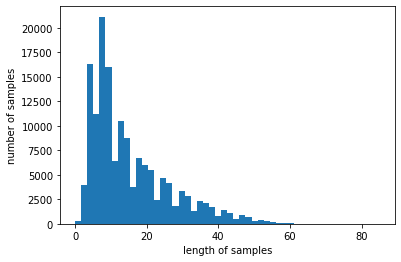

In [123]:
print('max length :',max(len(l) for l in X_train))
print('avg length :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [50]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('lower than %s length: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 80
below_threshold_len(max_len, X_train)

lower than 80 length: 99.99866666666667


In [51]:
#Padding with 80
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

#2. Classify the reviews with GRU

In [52]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [54]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [55]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 175s 87ms/step - loss: 0.3205 - acc: 0.8712 - val_loss: 0.2310 - val_acc: 0.9160

Epoch 00001: val_acc improved from -inf to 0.91600, saving model to best_model.h5
Epoch 2/15
2000/2000 [==============================] - 169s 85ms/step - loss: 0.2135 - acc: 0.9231 - val_loss: 0.2268 - val_acc: 0.9147

Epoch 00002: val_acc did not improve from 0.91600
Epoch 3/15
2000/2000 [==============================] - 169s 85ms/step - loss: 0.1977 - acc: 0.9293 - val_loss: 0.2096 - val_acc: 0.9258

Epoch 00003: val_acc improved from 0.91600 to 0.92580, saving model to best_model.h5
Epoch 4/15
2000/2000 [==============================] - 170s 85ms/step - loss: 0.1843 - acc: 0.9341 - val_loss: 0.2063 - val_acc: 0.9279

Epoch 00004: val_acc improved from 0.92580 to 0.92790, saving model to best_model.h5
Epoch 5/15
2000/2000 [==============================] - 170s 85ms/step - loss: 0.1752 - acc: 0.9389 - val_loss: 0.2101 - val_acc: 0.9271

Epoch 00

In [56]:
loaded_model = load_model('best_model.h5')
print("\n Accuracy: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1561/1561 [==============================] - 27s 17ms/step - loss: 0.2082 - acc: 0.9247

 Accuracy: 0.9247


predict the review with the trained model

In [125]:
def sentiment_predict(sentence):
  sentence = mecab.morphs(sentence)
  sentence = [word for word in sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad_new))

  if score > 0.5:
    print("{:.2f}% positive review.".format(score * 100))
  else:
    print("{:.2f}% negative review.".format((1 - score) * 100))

In [126]:
input = "진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?"
sentiment_predict(input)

99.26% negative review.


In [127]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

97.24% positive review.


In [128]:
sentiment_predict('아............................ 대박나세요')

95.34% positive review.


In [129]:
sentiment_predict('진짜 대박 짜증나게 좋아요 미쳤어요 이거 꼭 사세요')

69.33% positive review.
